In [1]:
# Dans ce notebook, nous avons testé le modèle de facebook : Prophet pour prédire l'évolution des imports de vêtements usagés en France pour les prochaines années.

In [2]:
#import des librairies utiles pour la prédiction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

# définition des warnings à ignorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


In [3]:
#import de  la table nécessaire depuis BigQuery

from google.colab import auth
auth.authenticate_user()

query = "SELECT * FROM projet-fripes.Data_cleaning_en_cours.onu_import_france_mois"
df = pd.read_gbq(query, project_id = "pragmatic-cache-475010-p8")
df.head()

,date_date,valeur,poids
0,2024-01-01,1000721.828,778452.798
1,2024-02-01,1083735.332,723710.161
2,2024-03-01,1137778.992,741058.641
3,2024-04-01,1103044.570,692344.461
4,2024-05-01,1153565.172,767205.030


In [4]:
# Mise en forme du dataframe

from datetime import date
df = df.rename(columns={'date_date':'ds', 'poids': 'y'})

In [5]:
# séparation des données en deux sections : train et test

train = df[df['ds'] < pd.Timestamp('2023-01-01')]
test = df[df['ds'] >= pd.Timestamp('2023-01-01')]

In [6]:
# vérification de la lon,gueur des sections train et test

print(f"Number of months in train data: {len(train)}")
print(f"Number of months in test data: {len(test)}")

Number of months in train data: 108
Number of months in test data: 24


In [7]:
#instanciation du modèle

m = Prophet()
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
future = m.make_future_dataframe(periods=150, freq='M')
future.tail()

,ds
253,2035-01-31
254,2035-02-28
255,2035-03-31
256,2035-04-30
257,2035-05-31


In [9]:
# prédiction

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
238,2033-10-31,1.726199e+06,1.480447e+06,1.997029e+06
239,2033-11-30,1.647524e+06,1.398392e+06,1.926831e+06
240,2033-12-31,1.605876e+06,1.349379e+06,1.859691e+06
241,2034-01-31,1.654717e+06,1.405010e+06,1.939883e+06
242,2034-02-28,1.810518e+06,1.547601e+06,2.064942e+06
243,2034-03-31,1.662737e+06,1.390817e+06,1.913402e+06
244,2034-04-30,1.733487e+06,1.486952e+06,2.011606e+06
245,2034-05-31,1.689144e+06,1.432639e+06,1.960486e+06
246,2034-06-30,1.704141e+06,1.461265e+06,1.970832e+06
247,2034-07-31,1.668035e+06,1.404587e+06,1.927981e+06


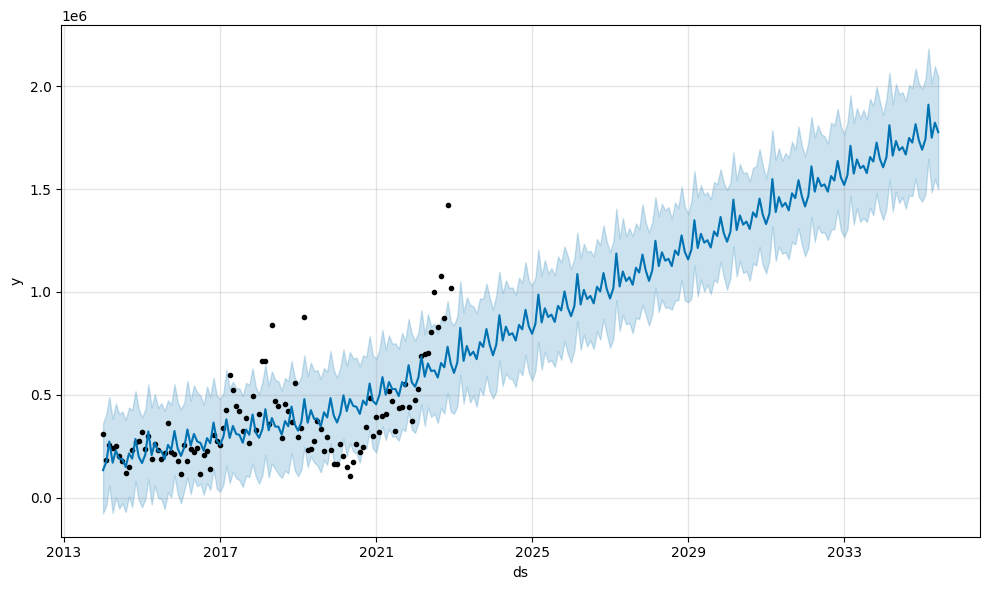

In [10]:
fig1 = m.plot(forecast)

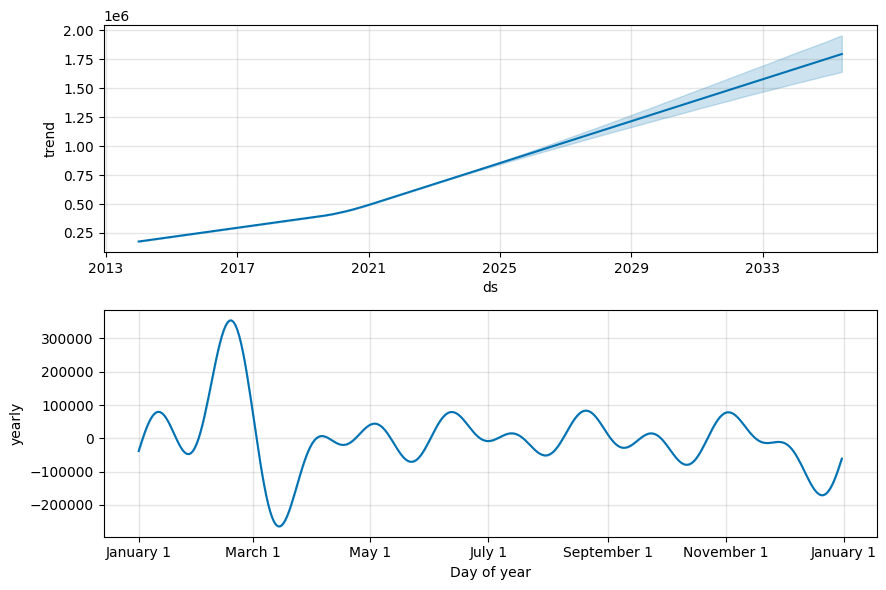

In [11]:
fig2 = m.plot_components(forecast)

In [12]:
# présentation de la prédiction sur un graphique

from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [13]:
# calcul de l'écart quadratique moyen (RMSE)

from statsmodels.tools.eval_measures import rmse

predictions = forecast.iloc[-len(test):]['yhat']
actuals = test['y']

print(f"RMSE: {round(rmse(predictions, actuals))}")

RMSE: 921747


In [14]:
# validation croisée

from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')


INFO:prophet:Making 13 forecasts with cutoffs between 2016-01-02 00:00:00 and 2021-12-01 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


In [15]:
# résultats de la validation croisée en tableau

df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-02-01,391786.289940,356117.001064,425781.285207,254567.0,2016-01-02
1,2016-03-01,87954.022687,52677.110060,124368.886245,179068.0,2016-01-02
2,2016-04-01,366530.190315,331949.839984,403835.099433,239334.0,2016-01-02
3,2016-05-01,331827.118102,295680.235490,366051.499118,223862.0,2016-01-02
4,2016-06-01,320145.812605,284325.491421,354004.561705,241881.0,2016-01-02


In [16]:
# indicateurs de performance du modèle

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head(20)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,2.234105e+10,149469.214941,123963.383293,0.544877,0.455048,0.416241,0.466667
1,37 days,1.664543e+10,129017.184138,107737.163729,0.386604,0.268437,0.353781,0.533333
2,41 days,2.108164e+10,145195.162832,118824.893450,0.384712,0.268437,0.365225,0.533333
3,42 days,1.925678e+10,138768.790524,112492.322619,0.376671,0.268437,0.345046,0.600000
4,46 days,2.160447e+10,146984.595555,123899.272501,0.410651,0.334591,0.370996,0.533333
5,47 days,2.162894e+10,147067.804461,124166.191949,0.413694,0.334591,0.373053,0.533333
6,51 days,2.155786e+10,146825.956485,123970.189479,0.417865,0.334591,0.375419,0.533333
7,53 days,2.219772e+10,148988.979074,126907.300201,0.441811,0.426663,0.391985,0.533333
8,57 days,2.090068e+10,144570.676585,123716.859290,0.387850,0.426663,0.366981,0.533333
9,58 days,2.045579e+10,143023.746976,121968.392202,0.369374,0.334591,0.358810,0.533333
